In [1]:
import datasets
from torchvision.transforms import ColorJitter, transforms
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
import pandas as pd
import numpy as np

Data from: [kaggle](https://www.kaggle.com/datasets/quadeer15sh/augmented-forest-segmentation/versions/2?resource=download)

Example code from: [huggingface](https://huggingface.co/blog/fine-tune-segformer)

In [2]:
meta_data = pd.read_csv('forest_seg_img/forest_segmented/meta_data.csv')

In [3]:
meta_data

,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg
...,...,...
5103,998002_sat_31.jpg,998002_mask_31.jpg
5104,998002_sat_32.jpg,998002_mask_32.jpg
5105,998002_sat_40.jpg,998002_mask_40.jpg
5106,998002_sat_41.jpg,998002_mask_41.jpg


In [4]:
IMAGES = [f"forest_seg_img/forest_segmented/images/{image_name}" for image_name in meta_data['image'][:51]]
MASKS = [f"forest_seg_img/forest_segmented/masks/{image_name}" for image_name in meta_data['mask'][:51]]
dataset = datasets.Dataset.from_dict({"pixel_values": IMAGES, "label": MASKS}, features=datasets.Features({"pixel_values": datasets.Image(), "label": datasets.Image()}))

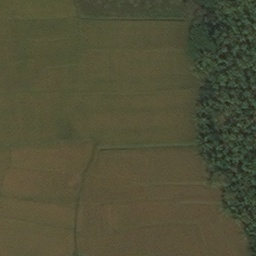

In [5]:
dataset["pixel_values"][0]

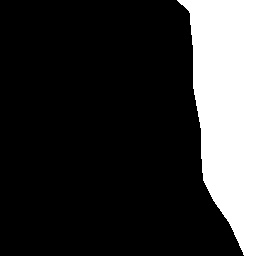

In [6]:
dataset["label"][0]

In [7]:
dataset

Dataset({
    features: ['pixel_values', 'label'],
    num_rows: 51
})

In [8]:
dataset[0]

{'pixel_values': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'label': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>}

In [9]:
dataset = dataset.train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]


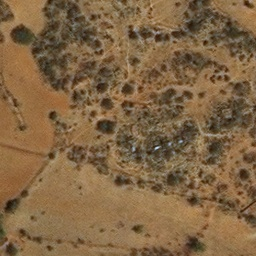

In [10]:
train_ds["pixel_values"][0]

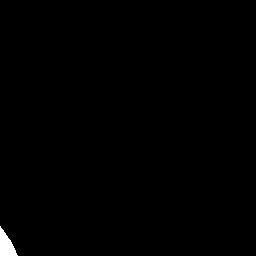

In [11]:
train_ds["label"][0]

In [12]:
id2label = {
    0: "unlabeled",
    1: "trees"
}

label2id = {
    "unlabeled": 0,
    "trees": 1
}

num_labels = len(id2label)

In [13]:
transform = transforms.Compose([
    transforms.PILToTensor()
])

In [14]:


feature_extractor = SegformerFeatureExtractor(return_tensors="pt")
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1) 

def train_transforms(example_batch):
    images = [transform(jitter(x)) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    new_labels = []
    for x in inputs['labels']:
        grayscale_arr = np.max(x, axis=2)
        grayscale_arr[grayscale_arr > 0] = 1
        new_labels.append(grayscale_arr)
    inputs['labels'] = new_labels
    return inputs


def val_transforms(example_batch):
    images = [transform(x)  for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    new_labels = []
    for x in inputs['labels']:
        grayscale_arr = np.max(x, axis=2)
        grayscale_arr[grayscale_arr > 0] = 1
        new_labels.append(grayscale_arr)
    inputs['labels'] = new_labels
    
    return inputs



/Users/eikerogall/Documents/neuefische/ds-fine-tuning-with-hf/.venv/lib/python3.11/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [17]:

# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [18]:


pretrained_model_name = "nvidia/mit-b0" 
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.classifier.bias', 'decode_head.batch_norm.r

In [19]:
from transformers import TrainingArguments

epochs = 50
lr = 0.00006
batch_size = 2


training_args = TrainingArguments(
    "model/segformer",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    hub_strategy="end",
)

In [20]:
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.do_reduce_labels,
        )
    
    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})
    
    return metrics

In [21]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [22]:
trainer.train()

/Users/eikerogall/Documents/neuefische/ds-fine-tuning-with-hf/.venv/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

{'loss': 0.6685, 'learning_rate': 5.994e-05, 'epoch': 0.05}
{'loss': 0.6843, 'learning_rate': 5.988e-05, 'epoch': 0.1}
{'loss': 0.6464, 'learning_rate': 5.982e-05, 'epoch': 0.15}
{'loss': 0.6857, 'learning_rate': 5.9760000000000004e-05, 'epoch': 0.2}
{'loss': 0.7183, 'learning_rate': 5.97e-05, 'epoch': 0.25}
{'loss': 0.6438, 'learning_rate': 5.964e-05, 'epoch': 0.3}
{'loss': 0.6239, 'learning_rate': 5.958e-05, 'epoch': 0.35}
{'loss': 0.6807, 'learning_rate': 5.952e-05, 'epoch': 0.4}
{'loss': 0.56, 'learning_rate': 5.946e-05, 'epoch': 0.45}
{'loss': 0.565, 'learning_rate': 5.94e-05, 'epoch': 0.5}
{'loss': 0.6204, 'learning_rate': 5.934e-05, 'epoch': 0.55}
{'loss': 0.5554, 'learning_rate': 5.928e-05, 'epoch': 0.6}
{'loss': 0.68, 'learning_rate': 5.922e-05, 'epoch': 0.65}
{'loss': 0.4947, 'learning_rate': 5.916e-05, 'epoch': 0.7}
{'loss': 0.6128, 'learning_rate': 5.91e-05, 'epoch': 0.75}
{'loss': 0.6259, 'learning_rate': 5.9040000000000004e-05, 'epoch': 0.8}
{'loss': 0.7232, 'learning_rat

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.5933942198753357, 'eval_mean_iou': 0.40127195515634984, 'eval_mean_accuracy': 0.8025439103126997, 'eval_overall_accuracy': 0.8025439103126997, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8025439103126997, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8025439103126997, 'eval_runtime': 5.1941, 'eval_samples_per_second': 2.118, 'eval_steps_per_second': 1.155, 'epoch': 1.0}
{'loss': 0.5823, 'learning_rate': 5.8740000000000003e-05, 'epoch': 1.05}
{'loss': 0.7009, 'learning_rate': 5.868e-05, 'epoch': 1.1}
{'loss': 0.6437, 'learning_rate': 5.862e-05, 'epoch': 1.15}
{'loss': 0.5588, 'learning_rate': 5.856e-05, 'epoch': 1.2}
{'loss': 0.5988, 'learning_rate': 5.85e-05, 'epoch': 1.25}
{'loss': 0.5193, 'learning_rate': 5.844e-05, 'epoch': 1.3}
{'loss': 0.3858, 'learning_rate': 5.838e-05, 'epoch': 1.35}
{'loss': 0.4362, 'learning_rate': 5.832e-05, 'epoch': 1.4}
{'loss': 0.5619, 'learning_rate': 5.826e-05, 'epoch': 1.45}
{'loss': 0.4865, 'learning_rate': 5.82e-05, 'epoc

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.43814173340797424, 'eval_mean_iou': 0.4631363396877529, 'eval_mean_accuracy': 0.9262726793755058, 'eval_overall_accuracy': 0.9262726793755058, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9262726793755058, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9262726793755058, 'eval_runtime': 5.1381, 'eval_samples_per_second': 2.141, 'eval_steps_per_second': 1.168, 'epoch': 2.0}
{'loss': 0.4817, 'learning_rate': 5.754e-05, 'epoch': 2.05}
{'loss': 0.6803, 'learning_rate': 5.748e-05, 'epoch': 2.1}
{'loss': 0.6929, 'learning_rate': 5.742e-05, 'epoch': 2.15}
{'loss': 0.5429, 'learning_rate': 5.736e-05, 'epoch': 2.2}
{'loss': 0.6155, 'learning_rate': 5.73e-05, 'epoch': 2.25}
{'loss': 0.5089, 'learning_rate': 5.724e-05, 'epoch': 2.3}
{'loss': 0.3399, 'learning_rate': 5.718e-05, 'epoch': 2.35}
{'loss': 0.6956, 'learning_rate': 5.712e-05, 'epoch': 2.4}
{'loss': 0.2183, 'learning_rate': 5.706e-05, 'epoch': 2.45}
{'loss': 0.3668, 'learning_rate': 5.6999999999999996e-05, 'epo

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.35443174839019775, 'eval_mean_iou': 0.44143850745674146, 'eval_mean_accuracy': 0.8828770149134829, 'eval_overall_accuracy': 0.8828770149134829, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8828770149134829, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8828770149134829, 'eval_runtime': 5.1347, 'eval_samples_per_second': 2.142, 'eval_steps_per_second': 1.169, 'epoch': 3.0}
{'loss': 0.5429, 'learning_rate': 5.634e-05, 'epoch': 3.05}
{'loss': 0.2202, 'learning_rate': 5.6279999999999996e-05, 'epoch': 3.1}
{'loss': 0.2264, 'learning_rate': 5.622000000000001e-05, 'epoch': 3.15}
{'loss': 0.5441, 'learning_rate': 5.6160000000000004e-05, 'epoch': 3.2}
{'loss': 0.3473, 'learning_rate': 5.61e-05, 'epoch': 3.25}
{'loss': 0.5105, 'learning_rate': 5.6040000000000006e-05, 'epoch': 3.3}
{'loss': 0.3083, 'learning_rate': 5.598e-05, 'epoch': 3.35}
{'loss': 0.3516, 'learning_rate': 5.592000000000001e-05, 'epoch': 3.4}
{'loss': 0.2921, 'learning_rate': 5.5860000000000004e-05, 

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.5324253439903259, 'eval_mean_iou': 0.33452723878772955, 'eval_mean_accuracy': 0.6690544775754591, 'eval_overall_accuracy': 0.6690544775754591, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.6690544775754591, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.6690544775754591, 'eval_runtime': 5.1292, 'eval_samples_per_second': 2.145, 'eval_steps_per_second': 1.17, 'epoch': 4.0}
{'loss': 0.5602, 'learning_rate': 5.5140000000000004e-05, 'epoch': 4.05}
{'loss': 0.7892, 'learning_rate': 5.508e-05, 'epoch': 4.1}
{'loss': 0.4321, 'learning_rate': 5.5020000000000005e-05, 'epoch': 4.15}
{'loss': 0.187, 'learning_rate': 5.496e-05, 'epoch': 4.2}
{'loss': 0.1945, 'learning_rate': 5.4900000000000006e-05, 'epoch': 4.25}
{'loss': 0.7021, 'learning_rate': 5.4840000000000003e-05, 'epoch': 4.3}
{'loss': 0.4019, 'learning_rate': 5.478e-05, 'epoch': 4.35}
{'loss': 0.7104, 'learning_rate': 5.4720000000000005e-05, 'epoch': 4.4}
{'loss': 0.4475, 'learning_rate': 5.466e-05, 'epoch': 4.45

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.36792847514152527, 'eval_mean_iou': 0.43604488529273844, 'eval_mean_accuracy': 0.8720897705854769, 'eval_overall_accuracy': 0.8720897705854769, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8720897705854769, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8720897705854769, 'eval_runtime': 5.3419, 'eval_samples_per_second': 2.059, 'eval_steps_per_second': 1.123, 'epoch': 5.0}
{'loss': 0.5818, 'learning_rate': 5.394e-05, 'epoch': 5.05}
{'loss': 0.1698, 'learning_rate': 5.3880000000000006e-05, 'epoch': 5.1}
{'loss': 0.5487, 'learning_rate': 5.382e-05, 'epoch': 5.15}
{'loss': 0.3385, 'learning_rate': 5.376e-05, 'epoch': 5.2}
{'loss': 0.9215, 'learning_rate': 5.3700000000000004e-05, 'epoch': 5.25}
{'loss': 0.4848, 'learning_rate': 5.364e-05, 'epoch': 5.3}
{'loss': 0.2884, 'learning_rate': 5.3580000000000005e-05, 'epoch': 5.35}
{'loss': 0.5411, 'learning_rate': 5.352e-05, 'epoch': 5.4}
{'loss': 0.2815, 'learning_rate': 5.346e-05, 'epoch': 5.45}
{'loss': 0.4137, 'lea

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.5535215139389038, 'eval_mean_iou': 0.335806617190428, 'eval_mean_accuracy': 0.671613234380856, 'eval_overall_accuracy': 0.671613234380856, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.671613234380856, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.671613234380856, 'eval_runtime': 5.172, 'eval_samples_per_second': 2.127, 'eval_steps_per_second': 1.16, 'epoch': 6.0}
{'loss': 0.4672, 'learning_rate': 5.274e-05, 'epoch': 6.05}
{'loss': 0.2935, 'learning_rate': 5.2680000000000004e-05, 'epoch': 6.1}
{'loss': 0.2983, 'learning_rate': 5.262e-05, 'epoch': 6.15}
{'loss': 0.2329, 'learning_rate': 5.256e-05, 'epoch': 6.2}
{'loss': 0.1636, 'learning_rate': 5.25e-05, 'epoch': 6.25}
{'loss': 0.4093, 'learning_rate': 5.244e-05, 'epoch': 6.3}
{'loss': 0.4156, 'learning_rate': 5.238e-05, 'epoch': 6.35}
{'loss': 0.3244, 'learning_rate': 5.232e-05, 'epoch': 6.4}
{'loss': 0.2859, 'learning_rate': 5.2260000000000004e-05, 'epoch': 6.45}
{'loss': 0.5398, 'learning_rate': 5.22e-05, 

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.40662047266960144, 'eval_mean_iou': 0.4266644366751823, 'eval_mean_accuracy': 0.8533288733503646, 'eval_overall_accuracy': 0.8533288733503646, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8533288733503646, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8533288733503646, 'eval_runtime': 5.4071, 'eval_samples_per_second': 2.034, 'eval_steps_per_second': 1.11, 'epoch': 7.0}
{'loss': 0.3379, 'learning_rate': 5.154e-05, 'epoch': 7.05}
{'loss': 0.2655, 'learning_rate': 5.148e-05, 'epoch': 7.1}
{'loss': 0.7899, 'learning_rate': 5.142e-05, 'epoch': 7.15}
{'loss': 0.1525, 'learning_rate': 5.136e-05, 'epoch': 7.2}
{'loss': 0.4568, 'learning_rate': 5.13e-05, 'epoch': 7.25}
{'loss': 0.9809, 'learning_rate': 5.124e-05, 'epoch': 7.3}
{'loss': 0.2032, 'learning_rate': 5.118e-05, 'epoch': 7.35}
{'loss': 0.2464, 'learning_rate': 5.112e-05, 'epoch': 7.4}
{'loss': 0.306, 'learning_rate': 5.106e-05, 'epoch': 7.45}
{'loss': 0.5869, 'learning_rate': 5.1e-05, 'epoch': 7.5}
{'loss'

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.28509849309921265, 'eval_mean_iou': 0.4792773741261843, 'eval_mean_accuracy': 0.9585547482523686, 'eval_overall_accuracy': 0.9585547482523686, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9585547482523686, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9585547482523686, 'eval_runtime': 5.0576, 'eval_samples_per_second': 2.175, 'eval_steps_per_second': 1.186, 'epoch': 8.0}
{'loss': 0.8787, 'learning_rate': 5.034e-05, 'epoch': 8.05}
{'loss': 0.4655, 'learning_rate': 5.028e-05, 'epoch': 8.1}
{'loss': 0.2652, 'learning_rate': 5.022e-05, 'epoch': 8.15}
{'loss': 0.555, 'learning_rate': 5.016e-05, 'epoch': 8.2}
{'loss': 0.1629, 'learning_rate': 5.01e-05, 'epoch': 8.25}
{'loss': 0.8706, 'learning_rate': 5.004e-05, 'epoch': 8.3}
{'loss': 0.3071, 'learning_rate': 4.998e-05, 'epoch': 8.35}
{'loss': 0.4186, 'learning_rate': 4.9919999999999996e-05, 'epoch': 8.4}
{'loss': 0.3677, 'learning_rate': 4.986e-05, 'epoch': 8.45}
{'loss': 0.4123, 'learning_rate': 4.98e-05, 'epoch

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.418771356344223, 'eval_mean_iou': 0.4164407253779066, 'eval_mean_accuracy': 0.8328814507558132, 'eval_overall_accuracy': 0.8328814507558132, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8328814507558132, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8328814507558132, 'eval_runtime': 5.1774, 'eval_samples_per_second': 2.125, 'eval_steps_per_second': 1.159, 'epoch': 9.0}
{'loss': 0.3966, 'learning_rate': 4.914e-05, 'epoch': 9.05}
{'loss': 0.4854, 'learning_rate': 4.908e-05, 'epoch': 9.1}
{'loss': 0.3941, 'learning_rate': 4.9019999999999995e-05, 'epoch': 9.15}
{'loss': 0.5856, 'learning_rate': 4.896e-05, 'epoch': 9.2}
{'loss': 0.4063, 'learning_rate': 4.8899999999999996e-05, 'epoch': 9.25}
{'loss': 0.2766, 'learning_rate': 4.884e-05, 'epoch': 9.3}
{'loss': 0.4028, 'learning_rate': 4.878e-05, 'epoch': 9.35}
{'loss': 0.3616, 'learning_rate': 4.872000000000001e-05, 'epoch': 9.4}
{'loss': 0.4001, 'learning_rate': 4.8660000000000005e-05, 'epoch': 9.45}
{'loss': 0.2

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.353691428899765, 'eval_mean_iou': 0.4380652304193772, 'eval_mean_accuracy': 0.8761304608387545, 'eval_overall_accuracy': 0.8761304608387545, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8761304608387545, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8761304608387545, 'eval_runtime': 5.069, 'eval_samples_per_second': 2.17, 'eval_steps_per_second': 1.184, 'epoch': 10.0}
{'loss': 0.3917, 'learning_rate': 4.7940000000000005e-05, 'epoch': 10.05}
{'loss': 0.475, 'learning_rate': 4.788e-05, 'epoch': 10.1}
{'loss': 0.1836, 'learning_rate': 4.7820000000000006e-05, 'epoch': 10.15}
{'loss': 0.6628, 'learning_rate': 4.7760000000000004e-05, 'epoch': 10.2}
{'loss': 0.9124, 'learning_rate': 4.77e-05, 'epoch': 10.25}
{'loss': 0.1479, 'learning_rate': 4.7640000000000005e-05, 'epoch': 10.3}
{'loss': 0.1702, 'learning_rate': 4.758e-05, 'epoch': 10.35}
{'loss': 0.1531, 'learning_rate': 4.7520000000000006e-05, 'epoch': 10.4}
{'loss': 0.4844, 'learning_rate': 4.746e-05, 'epoch':

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.35646092891693115, 'eval_mean_iou': 0.4476029703848682, 'eval_mean_accuracy': 0.8952059407697364, 'eval_overall_accuracy': 0.8952059407697364, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8952059407697364, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8952059407697364, 'eval_runtime': 4.9983, 'eval_samples_per_second': 2.201, 'eval_steps_per_second': 1.2, 'epoch': 11.0}
{'loss': 0.2241, 'learning_rate': 4.674e-05, 'epoch': 11.05}
{'loss': 0.2888, 'learning_rate': 4.668e-05, 'epoch': 11.1}
{'loss': 0.3182, 'learning_rate': 4.6620000000000004e-05, 'epoch': 11.15}
{'loss': 0.2882, 'learning_rate': 4.656e-05, 'epoch': 11.2}
{'loss': 0.1564, 'learning_rate': 4.6500000000000005e-05, 'epoch': 11.25}
{'loss': 1.0495, 'learning_rate': 4.644e-05, 'epoch': 11.3}
{'loss': 0.4045, 'learning_rate': 4.638e-05, 'epoch': 11.35}
{'loss': 0.2425, 'learning_rate': 4.6320000000000004e-05, 'epoch': 11.4}
{'loss': 0.9516, 'learning_rate': 4.626e-05, 'epoch': 11.45}
{'loss': 0.226

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3000207543373108, 'eval_mean_iou': 0.4895370700627717, 'eval_mean_accuracy': 0.9790741401255434, 'eval_overall_accuracy': 0.9790741401255434, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9790741401255434, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9790741401255434, 'eval_runtime': 5.1589, 'eval_samples_per_second': 2.132, 'eval_steps_per_second': 1.163, 'epoch': 12.0}
{'loss': 0.2622, 'learning_rate': 4.554e-05, 'epoch': 12.05}
{'loss': 0.2087, 'learning_rate': 4.548e-05, 'epoch': 12.1}
{'loss': 0.6481, 'learning_rate': 4.542e-05, 'epoch': 12.15}
{'loss': 0.3049, 'learning_rate': 4.536e-05, 'epoch': 12.2}
{'loss': 0.2785, 'learning_rate': 4.53e-05, 'epoch': 12.25}
{'loss': 0.1616, 'learning_rate': 4.524e-05, 'epoch': 12.3}
{'loss': 0.6494, 'learning_rate': 4.5180000000000004e-05, 'epoch': 12.35}
{'loss': 0.194, 'learning_rate': 4.512e-05, 'epoch': 12.4}
{'loss': 0.2389, 'learning_rate': 4.506e-05, 'epoch': 12.45}
{'loss': 0.6845, 'learning_rate': 4.5e-05

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3216615915298462, 'eval_mean_iou': 0.45854230073562563, 'eval_mean_accuracy': 0.9170846014712513, 'eval_overall_accuracy': 0.9170846014712513, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9170846014712513, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9170846014712513, 'eval_runtime': 5.0488, 'eval_samples_per_second': 2.179, 'eval_steps_per_second': 1.188, 'epoch': 13.0}
{'loss': 0.5677, 'learning_rate': 4.434e-05, 'epoch': 13.05}
{'loss': 0.2081, 'learning_rate': 4.428e-05, 'epoch': 13.1}
{'loss': 0.1382, 'learning_rate': 4.422e-05, 'epoch': 13.15}
{'loss': 0.3265, 'learning_rate': 4.416e-05, 'epoch': 13.2}
{'loss': 0.2117, 'learning_rate': 4.41e-05, 'epoch': 13.25}
{'loss': 0.3405, 'learning_rate': 4.404e-05, 'epoch': 13.3}
{'loss': 0.2485, 'learning_rate': 4.398e-05, 'epoch': 13.35}
{'loss': 0.2774, 'learning_rate': 4.392e-05, 'epoch': 13.4}
{'loss': 0.3871, 'learning_rate': 4.386e-05, 'epoch': 13.45}
{'loss': 0.3207, 'learning_rate': 4.38e-05, 'epoch':

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.585556149482727, 'eval_mean_iou': 0.3767193415399434, 'eval_mean_accuracy': 0.7534386830798868, 'eval_overall_accuracy': 0.7534386830798868, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.7534386830798868, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.7534386830798868, 'eval_runtime': 5.1808, 'eval_samples_per_second': 2.123, 'eval_steps_per_second': 1.158, 'epoch': 14.0}
{'loss': 0.3026, 'learning_rate': 4.314e-05, 'epoch': 14.05}
{'loss': 0.4459, 'learning_rate': 4.308e-05, 'epoch': 14.1}
{'loss': 0.2506, 'learning_rate': 4.302e-05, 'epoch': 14.15}
{'loss': 0.2278, 'learning_rate': 4.296e-05, 'epoch': 14.2}
{'loss': 0.379, 'learning_rate': 4.29e-05, 'epoch': 14.25}
{'loss': 0.3468, 'learning_rate': 4.2839999999999996e-05, 'epoch': 14.3}
{'loss': 0.1754, 'learning_rate': 4.278e-05, 'epoch': 14.35}
{'loss': 0.2459, 'learning_rate': 4.272e-05, 'epoch': 14.4}
{'loss': 0.9281, 'learning_rate': 4.266e-05, 'epoch': 14.45}
{'loss': 0.2994, 'learning_rate': 4.26e-05

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.296795517206192, 'eval_mean_iou': 0.4773726777460127, 'eval_mean_accuracy': 0.9547453554920254, 'eval_overall_accuracy': 0.9547453554920254, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9547453554920254, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9547453554920254, 'eval_runtime': 5.1311, 'eval_samples_per_second': 2.144, 'eval_steps_per_second': 1.169, 'epoch': 15.0}
{'loss': 0.5069, 'learning_rate': 4.194e-05, 'epoch': 15.05}
{'loss': 0.4393, 'learning_rate': 4.188e-05, 'epoch': 15.1}
{'loss': 0.0834, 'learning_rate': 4.1819999999999996e-05, 'epoch': 15.15}
{'loss': 0.8497, 'learning_rate': 4.176e-05, 'epoch': 15.2}
{'loss': 0.1774, 'learning_rate': 4.17e-05, 'epoch': 15.25}
{'loss': 0.7209, 'learning_rate': 4.164e-05, 'epoch': 15.3}
{'loss': 0.3019, 'learning_rate': 4.158e-05, 'epoch': 15.35}
{'loss': 0.261, 'learning_rate': 4.1519999999999995e-05, 'epoch': 15.4}
{'loss': 0.2004, 'learning_rate': 4.146e-05, 'epoch': 15.45}
{'loss': 0.1224, 'learning_ra

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.36408567428588867, 'eval_mean_iou': 0.4586040856823683, 'eval_mean_accuracy': 0.9172081713647366, 'eval_overall_accuracy': 0.9172081713647366, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9172081713647366, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9172081713647366, 'eval_runtime': 5.251, 'eval_samples_per_second': 2.095, 'eval_steps_per_second': 1.143, 'epoch': 16.0}
{'loss': 0.1688, 'learning_rate': 4.0740000000000006e-05, 'epoch': 16.05}
{'loss': 0.1074, 'learning_rate': 4.0680000000000004e-05, 'epoch': 16.1}
{'loss': 0.1908, 'learning_rate': 4.062e-05, 'epoch': 16.15}
{'loss': 0.0976, 'learning_rate': 4.0560000000000005e-05, 'epoch': 16.2}
{'loss': 0.2038, 'learning_rate': 4.05e-05, 'epoch': 16.25}
{'loss': 0.1111, 'learning_rate': 4.0440000000000006e-05, 'epoch': 16.3}
{'loss': 0.21, 'learning_rate': 4.038e-05, 'epoch': 16.35}
{'loss': 0.4246, 'learning_rate': 4.032e-05, 'epoch': 16.4}
{'loss': 0.2168, 'learning_rate': 4.0260000000000004e-05, 'epoch

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3447655439376831, 'eval_mean_iou': 0.4588195408812661, 'eval_mean_accuracy': 0.9176390817625322, 'eval_overall_accuracy': 0.9176390817625322, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9176390817625322, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9176390817625322, 'eval_runtime': 5.1617, 'eval_samples_per_second': 2.131, 'eval_steps_per_second': 1.162, 'epoch': 17.0}
{'loss': 0.1424, 'learning_rate': 3.9540000000000004e-05, 'epoch': 17.05}
{'loss': 0.4592, 'learning_rate': 3.948e-05, 'epoch': 17.1}
{'loss': 0.1239, 'learning_rate': 3.9420000000000005e-05, 'epoch': 17.15}
{'loss': 1.0464, 'learning_rate': 3.936e-05, 'epoch': 17.2}
{'loss': 0.3561, 'learning_rate': 3.93e-05, 'epoch': 17.25}
{'loss': 0.297, 'learning_rate': 3.9240000000000004e-05, 'epoch': 17.3}
{'loss': 0.2559, 'learning_rate': 3.918e-05, 'epoch': 17.35}
{'loss': 0.5231, 'learning_rate': 3.9120000000000005e-05, 'epoch': 17.4}
{'loss': 0.1148, 'learning_rate': 3.906e-05, 'epoch': 17.45}
{'

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3495374023914337, 'eval_mean_iou': 0.47508097675437566, 'eval_mean_accuracy': 0.9501619535087513, 'eval_overall_accuracy': 0.9501619535087513, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9501619535087513, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9501619535087513, 'eval_runtime': 5.1297, 'eval_samples_per_second': 2.144, 'eval_steps_per_second': 1.17, 'epoch': 18.0}
{'loss': 0.2417, 'learning_rate': 3.834e-05, 'epoch': 18.05}
{'loss': 0.0909, 'learning_rate': 3.828e-05, 'epoch': 18.1}
{'loss': 0.1314, 'learning_rate': 3.822e-05, 'epoch': 18.15}
{'loss': 0.2303, 'learning_rate': 3.816e-05, 'epoch': 18.2}
{'loss': 0.1522, 'learning_rate': 3.8100000000000005e-05, 'epoch': 18.25}
{'loss': 0.2273, 'learning_rate': 3.804e-05, 'epoch': 18.3}
{'loss': 0.1746, 'learning_rate': 3.798e-05, 'epoch': 18.35}
{'loss': 0.213, 'learning_rate': 3.792e-05, 'epoch': 18.4}
{'loss': 0.1648, 'learning_rate': 3.786e-05, 'epoch': 18.45}
{'loss': 0.2262, 'learning_rate': 3.7800

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.41668450832366943, 'eval_mean_iou': 0.4436206703010398, 'eval_mean_accuracy': 0.8872413406020796, 'eval_overall_accuracy': 0.8872413406020796, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8872413406020796, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8872413406020796, 'eval_runtime': 4.992, 'eval_samples_per_second': 2.204, 'eval_steps_per_second': 1.202, 'epoch': 19.0}
{'loss': 0.1213, 'learning_rate': 3.714e-05, 'epoch': 19.05}
{'loss': 0.3362, 'learning_rate': 3.708e-05, 'epoch': 19.1}
{'loss': 0.0953, 'learning_rate': 3.702e-05, 'epoch': 19.15}
{'loss': 0.2467, 'learning_rate': 3.696e-05, 'epoch': 19.2}
{'loss': 0.1775, 'learning_rate': 3.69e-05, 'epoch': 19.25}
{'loss': 0.2404, 'learning_rate': 3.684e-05, 'epoch': 19.3}
{'loss': 0.2724, 'learning_rate': 3.6780000000000004e-05, 'epoch': 19.35}
{'loss': 0.1863, 'learning_rate': 3.672e-05, 'epoch': 19.4}
{'loss': 0.3591, 'learning_rate': 3.666e-05, 'epoch': 19.45}
{'loss': 0.0627, 'learning_rate': 3.66e-

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.4726063907146454, 'eval_mean_iou': 0.4179203956409249, 'eval_mean_accuracy': 0.8358407912818498, 'eval_overall_accuracy': 0.8358407912818498, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8358407912818498, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8358407912818498, 'eval_runtime': 5.1848, 'eval_samples_per_second': 2.122, 'eval_steps_per_second': 1.157, 'epoch': 20.0}
{'loss': 0.218, 'learning_rate': 3.594e-05, 'epoch': 20.05}
{'loss': 0.2523, 'learning_rate': 3.588e-05, 'epoch': 20.1}
{'loss': 0.241, 'learning_rate': 3.582e-05, 'epoch': 20.15}
{'loss': 0.1884, 'learning_rate': 3.5759999999999996e-05, 'epoch': 20.2}
{'loss': 0.0761, 'learning_rate': 3.57e-05, 'epoch': 20.25}
{'loss': 0.1904, 'learning_rate': 3.564e-05, 'epoch': 20.3}
{'loss': 0.3576, 'learning_rate': 3.558e-05, 'epoch': 20.35}
{'loss': 0.2905, 'learning_rate': 3.552e-05, 'epoch': 20.4}
{'loss': 0.1919, 'learning_rate': 3.5459999999999996e-05, 'epoch': 20.45}
{'loss': 0.2689, 'learning_ra

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3513072729110718, 'eval_mean_iou': 0.4486347563636232, 'eval_mean_accuracy': 0.8972695127272464, 'eval_overall_accuracy': 0.8972695127272464, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8972695127272464, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8972695127272464, 'eval_runtime': 5.062, 'eval_samples_per_second': 2.173, 'eval_steps_per_second': 1.185, 'epoch': 21.0}
{'loss': 0.3257, 'learning_rate': 3.4739999999999996e-05, 'epoch': 21.05}
{'loss': 0.1255, 'learning_rate': 3.468e-05, 'epoch': 21.1}
{'loss': 0.3486, 'learning_rate': 3.462e-05, 'epoch': 21.15}
{'loss': 0.3483, 'learning_rate': 3.456e-05, 'epoch': 21.2}
{'loss': 0.1021, 'learning_rate': 3.45e-05, 'epoch': 21.25}
{'loss': 0.1867, 'learning_rate': 3.4439999999999996e-05, 'epoch': 21.3}
{'loss': 0.2586, 'learning_rate': 3.438e-05, 'epoch': 21.35}
{'loss': 0.1567, 'learning_rate': 3.432e-05, 'epoch': 21.4}
{'loss': 0.1782, 'learning_rate': 3.426e-05, 'epoch': 21.45}
{'loss': 0.2145, 'learning_r

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.33006566762924194, 'eval_mean_iou': 0.4675185445367623, 'eval_mean_accuracy': 0.9350370890735246, 'eval_overall_accuracy': 0.9350370890735246, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9350370890735246, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9350370890735246, 'eval_runtime': 4.9479, 'eval_samples_per_second': 2.223, 'eval_steps_per_second': 1.213, 'epoch': 22.0}
{'loss': 0.1326, 'learning_rate': 3.354e-05, 'epoch': 22.05}
{'loss': 0.0705, 'learning_rate': 3.3480000000000005e-05, 'epoch': 22.1}
{'loss': 0.1377, 'learning_rate': 3.342e-05, 'epoch': 22.15}
{'loss': 0.1244, 'learning_rate': 3.3360000000000006e-05, 'epoch': 22.2}
{'loss': 0.3264, 'learning_rate': 3.33e-05, 'epoch': 22.25}
{'loss': 0.1119, 'learning_rate': 3.324000000000001e-05, 'epoch': 22.3}
{'loss': 0.1339, 'learning_rate': 3.3180000000000004e-05, 'epoch': 22.35}
{'loss': 0.1565, 'learning_rate': 3.312e-05, 'epoch': 22.4}
{'loss': 0.2465, 'learning_rate': 3.3060000000000005e-05, 'epo

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.36705389618873596, 'eval_mean_iou': 0.4609505557476748, 'eval_mean_accuracy': 0.9219011114953496, 'eval_overall_accuracy': 0.9219011114953496, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9219011114953496, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9219011114953496, 'eval_runtime': 5.0308, 'eval_samples_per_second': 2.187, 'eval_steps_per_second': 1.193, 'epoch': 23.0}
{'loss': 0.1826, 'learning_rate': 3.2340000000000005e-05, 'epoch': 23.05}
{'loss': 0.2639, 'learning_rate': 3.228e-05, 'epoch': 23.1}
{'loss': 0.1254, 'learning_rate': 3.222e-05, 'epoch': 23.15}
{'loss': 0.198, 'learning_rate': 3.2160000000000004e-05, 'epoch': 23.2}
{'loss': 0.1003, 'learning_rate': 3.21e-05, 'epoch': 23.25}
{'loss': 0.3254, 'learning_rate': 3.2040000000000005e-05, 'epoch': 23.3}
{'loss': 0.1769, 'learning_rate': 3.198e-05, 'epoch': 23.35}
{'loss': 0.1723, 'learning_rate': 3.192e-05, 'epoch': 23.4}
{'loss': 0.2446, 'learning_rate': 3.186e-05, 'epoch': 23.45}
{'loss': 0.178

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.4328119158744812, 'eval_mean_iou': 0.4369546856074117, 'eval_mean_accuracy': 0.8739093712148234, 'eval_overall_accuracy': 0.8739093712148234, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.8739093712148234, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.8739093712148234, 'eval_runtime': 5.0764, 'eval_samples_per_second': 2.167, 'eval_steps_per_second': 1.182, 'epoch': 24.0}
{'loss': 0.1308, 'learning_rate': 3.1140000000000003e-05, 'epoch': 24.05}
{'loss': 0.4143, 'learning_rate': 3.108e-05, 'epoch': 24.1}
{'loss': 0.1772, 'learning_rate': 3.1020000000000005e-05, 'epoch': 24.15}
{'loss': 0.1913, 'learning_rate': 3.096e-05, 'epoch': 24.2}
{'loss': 0.9324, 'learning_rate': 3.09e-05, 'epoch': 24.25}
{'loss': 0.1596, 'learning_rate': 3.084e-05, 'epoch': 24.3}
{'loss': 0.4546, 'learning_rate': 3.078e-05, 'epoch': 24.35}
{'loss': 0.1712, 'learning_rate': 3.0720000000000004e-05, 'epoch': 24.4}
{'loss': 0.1933, 'learning_rate': 3.066e-05, 'epoch': 24.45}
{'loss': 0.112

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3922940194606781, 'eval_mean_iou': 0.4489233124335755, 'eval_mean_accuracy': 0.897846624867151, 'eval_overall_accuracy': 0.897846624867151, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.897846624867151, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.897846624867151, 'eval_runtime': 5.2544, 'eval_samples_per_second': 2.093, 'eval_steps_per_second': 1.142, 'epoch': 25.0}
{'loss': 1.1823, 'learning_rate': 2.994e-05, 'epoch': 25.05}
{'loss': 0.1176, 'learning_rate': 2.9880000000000002e-05, 'epoch': 25.1}
{'loss': 0.4053, 'learning_rate': 2.982e-05, 'epoch': 25.15}
{'loss': 0.5308, 'learning_rate': 2.976e-05, 'epoch': 25.2}
{'loss': 0.5523, 'learning_rate': 2.97e-05, 'epoch': 25.25}
{'loss': 0.1448, 'learning_rate': 2.964e-05, 'epoch': 25.3}
{'loss': 0.2056, 'learning_rate': 2.958e-05, 'epoch': 25.35}
{'loss': 0.1675, 'learning_rate': 2.9520000000000002e-05, 'epoch': 25.4}
{'loss': 0.1417, 'learning_rate': 2.946e-05, 'epoch': 25.45}
{'loss': 0.1207, 'learning_rate

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3535926640033722, 'eval_mean_iou': 0.47659391583487076, 'eval_mean_accuracy': 0.9531878316697415, 'eval_overall_accuracy': 0.9531878316697415, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9531878316697415, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9531878316697415, 'eval_runtime': 5.0921, 'eval_samples_per_second': 2.16, 'eval_steps_per_second': 1.178, 'epoch': 26.0}
{'loss': 0.2255, 'learning_rate': 2.874e-05, 'epoch': 26.05}
{'loss': 0.1862, 'learning_rate': 2.868e-05, 'epoch': 26.1}
{'loss': 0.4803, 'learning_rate': 2.862e-05, 'epoch': 26.15}
{'loss': 0.0518, 'learning_rate': 2.856e-05, 'epoch': 26.2}
{'loss': 0.1527, 'learning_rate': 2.8499999999999998e-05, 'epoch': 26.25}
{'loss': 0.2495, 'learning_rate': 2.844e-05, 'epoch': 26.3}
{'loss': 0.0646, 'learning_rate': 2.838e-05, 'epoch': 26.35}
{'loss': 0.3388, 'learning_rate': 2.832e-05, 'epoch': 26.4}
{'loss': 0.2169, 'learning_rate': 2.826e-05, 'epoch': 26.45}
{'loss': 0.0784, 'learning_rate': 2.819

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3480035066604614, 'eval_mean_iou': 0.4836036783090931, 'eval_mean_accuracy': 0.9672073566181862, 'eval_overall_accuracy': 0.9672073566181862, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9672073566181862, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9672073566181862, 'eval_runtime': 5.1443, 'eval_samples_per_second': 2.138, 'eval_steps_per_second': 1.166, 'epoch': 27.0}
{'loss': 0.2608, 'learning_rate': 2.754e-05, 'epoch': 27.05}
{'loss': 0.1836, 'learning_rate': 2.748e-05, 'epoch': 27.1}
{'loss': 0.5002, 'learning_rate': 2.7420000000000002e-05, 'epoch': 27.15}
{'loss': 0.0688, 'learning_rate': 2.7360000000000002e-05, 'epoch': 27.2}
{'loss': 0.2356, 'learning_rate': 2.7300000000000003e-05, 'epoch': 27.25}
{'loss': 0.1021, 'learning_rate': 2.724e-05, 'epoch': 27.3}
{'loss': 0.1655, 'learning_rate': 2.718e-05, 'epoch': 27.35}
{'loss': 0.0864, 'learning_rate': 2.712e-05, 'epoch': 27.4}
{'loss': 0.1084, 'learning_rate': 2.7060000000000002e-05, 'epoch': 27.45}


  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.35224905610084534, 'eval_mean_iou': 0.4763653341637713, 'eval_mean_accuracy': 0.9527306683275426, 'eval_overall_accuracy': 0.9527306683275426, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9527306683275426, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9527306683275426, 'eval_runtime': 5.0896, 'eval_samples_per_second': 2.161, 'eval_steps_per_second': 1.179, 'epoch': 28.0}
{'loss': 0.0462, 'learning_rate': 2.6340000000000002e-05, 'epoch': 28.05}
{'loss': 0.2246, 'learning_rate': 2.628e-05, 'epoch': 28.1}
{'loss': 0.2062, 'learning_rate': 2.622e-05, 'epoch': 28.15}
{'loss': 0.0916, 'learning_rate': 2.616e-05, 'epoch': 28.2}
{'loss': 0.0853, 'learning_rate': 2.61e-05, 'epoch': 28.25}
{'loss': 0.4661, 'learning_rate': 2.604e-05, 'epoch': 28.3}
{'loss': 0.2635, 'learning_rate': 2.5980000000000002e-05, 'epoch': 28.35}
{'loss': 0.0932, 'learning_rate': 2.592e-05, 'epoch': 28.4}
{'loss': 0.0832, 'learning_rate': 2.586e-05, 'epoch': 28.45}
{'loss': 0.1388, 'learning

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.35372307896614075, 'eval_mean_iou': 0.46877506477235076, 'eval_mean_accuracy': 0.9375501295447015, 'eval_overall_accuracy': 0.9375501295447015, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9375501295447015, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9375501295447015, 'eval_runtime': 5.0845, 'eval_samples_per_second': 2.163, 'eval_steps_per_second': 1.18, 'epoch': 29.0}
{'loss': 0.1002, 'learning_rate': 2.514e-05, 'epoch': 29.05}
{'loss': 0.0556, 'learning_rate': 2.508e-05, 'epoch': 29.1}
{'loss': 0.1494, 'learning_rate': 2.502e-05, 'epoch': 29.15}
{'loss': 0.0973, 'learning_rate': 2.4959999999999998e-05, 'epoch': 29.2}
{'loss': 0.3303, 'learning_rate': 2.49e-05, 'epoch': 29.25}
{'loss': 0.1799, 'learning_rate': 2.484e-05, 'epoch': 29.3}
{'loss': 0.063, 'learning_rate': 2.478e-05, 'epoch': 29.35}
{'loss': 0.3274, 'learning_rate': 2.472e-05, 'epoch': 29.4}
{'loss': 0.0967, 'learning_rate': 2.4659999999999998e-05, 'epoch': 29.45}
{'loss': 0.0969, 'learning_

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3728921711444855, 'eval_mean_iou': 0.4853633045395867, 'eval_mean_accuracy': 0.9707266090791734, 'eval_overall_accuracy': 0.9707266090791734, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9707266090791734, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9707266090791734, 'eval_runtime': 5.2081, 'eval_samples_per_second': 2.112, 'eval_steps_per_second': 1.152, 'epoch': 30.0}
{'loss': 0.3545, 'learning_rate': 2.394e-05, 'epoch': 30.05}
{'loss': 0.1301, 'learning_rate': 2.3880000000000002e-05, 'epoch': 30.1}
{'loss': 0.1623, 'learning_rate': 2.3820000000000002e-05, 'epoch': 30.15}
{'loss': 0.1137, 'learning_rate': 2.3760000000000003e-05, 'epoch': 30.2}
{'loss': 0.1664, 'learning_rate': 2.37e-05, 'epoch': 30.25}
{'loss': 0.2371, 'learning_rate': 2.364e-05, 'epoch': 30.3}
{'loss': 0.092, 'learning_rate': 2.358e-05, 'epoch': 30.35}
{'loss': 0.4048, 'learning_rate': 2.3520000000000002e-05, 'epoch': 30.4}
{'loss': 0.1257, 'learning_rate': 2.3460000000000002e-05, 'epoc

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.38416507840156555, 'eval_mean_iou': 0.467509718115799, 'eval_mean_accuracy': 0.935019436231598, 'eval_overall_accuracy': 0.935019436231598, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.935019436231598, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.935019436231598, 'eval_runtime': 5.0602, 'eval_samples_per_second': 2.174, 'eval_steps_per_second': 1.186, 'epoch': 31.0}
{'loss': 0.1083, 'learning_rate': 2.274e-05, 'epoch': 31.05}
{'loss': 0.1776, 'learning_rate': 2.268e-05, 'epoch': 31.1}
{'loss': 0.0997, 'learning_rate': 2.262e-05, 'epoch': 31.15}
{'loss': 0.0518, 'learning_rate': 2.256e-05, 'epoch': 31.2}
{'loss': 0.1561, 'learning_rate': 2.25e-05, 'epoch': 31.25}
{'loss': 0.1191, 'learning_rate': 2.2440000000000002e-05, 'epoch': 31.3}
{'loss': 0.2434, 'learning_rate': 2.238e-05, 'epoch': 31.35}
{'loss': 0.1029, 'learning_rate': 2.232e-05, 'epoch': 31.4}
{'loss': 0.0871, 'learning_rate': 2.226e-05, 'epoch': 31.45}
{'loss': 0.1648, 'learning_rate': 2.22e-05, 

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.416653037071228, 'eval_mean_iou': 0.45641105955073064, 'eval_mean_accuracy': 0.9128221191014613, 'eval_overall_accuracy': 0.9128221191014613, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9128221191014613, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9128221191014613, 'eval_runtime': 5.037, 'eval_samples_per_second': 2.184, 'eval_steps_per_second': 1.191, 'epoch': 32.0}
{'loss': 0.1399, 'learning_rate': 2.154e-05, 'epoch': 32.05}
{'loss': 0.1447, 'learning_rate': 2.148e-05, 'epoch': 32.1}
{'loss': 0.141, 'learning_rate': 2.1419999999999998e-05, 'epoch': 32.15}
{'loss': 0.3287, 'learning_rate': 2.136e-05, 'epoch': 32.2}
{'loss': 0.2155, 'learning_rate': 2.13e-05, 'epoch': 32.25}
{'loss': 0.0874, 'learning_rate': 2.124e-05, 'epoch': 32.3}
{'loss': 0.074, 'learning_rate': 2.118e-05, 'epoch': 32.35}
{'loss': 0.1492, 'learning_rate': 2.1119999999999998e-05, 'epoch': 32.4}
{'loss': 0.0729, 'learning_rate': 2.1059999999999998e-05, 'epoch': 32.45}
{'loss': 0.0849, 

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3899497985839844, 'eval_mean_iou': 0.46559687427012286, 'eval_mean_accuracy': 0.9311937485402457, 'eval_overall_accuracy': 0.9311937485402457, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9311937485402457, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9311937485402457, 'eval_runtime': 5.2576, 'eval_samples_per_second': 2.092, 'eval_steps_per_second': 1.141, 'epoch': 33.0}
{'loss': 0.0829, 'learning_rate': 2.0340000000000002e-05, 'epoch': 33.05}
{'loss': 0.1285, 'learning_rate': 2.0280000000000002e-05, 'epoch': 33.1}
{'loss': 0.061, 'learning_rate': 2.0220000000000003e-05, 'epoch': 33.15}
{'loss': 0.0362, 'learning_rate': 2.016e-05, 'epoch': 33.2}
{'loss': 0.1122, 'learning_rate': 2.01e-05, 'epoch': 33.25}
{'loss': 0.3291, 'learning_rate': 2.004e-05, 'epoch': 33.3}
{'loss': 0.0799, 'learning_rate': 1.9980000000000002e-05, 'epoch': 33.35}
{'loss': 0.1006, 'learning_rate': 1.9920000000000002e-05, 'epoch': 33.4}
{'loss': 0.0506, 'learning_rate': 1.9860000000000

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.43009230494499207, 'eval_mean_iou': 0.4732939659870473, 'eval_mean_accuracy': 0.9465879319740946, 'eval_overall_accuracy': 0.9465879319740946, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9465879319740946, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9465879319740946, 'eval_runtime': 5.2243, 'eval_samples_per_second': 2.106, 'eval_steps_per_second': 1.148, 'epoch': 34.0}
{'loss': 0.1562, 'learning_rate': 1.914e-05, 'epoch': 34.05}
{'loss': 0.1226, 'learning_rate': 1.908e-05, 'epoch': 34.1}
{'loss': 0.6877, 'learning_rate': 1.902e-05, 'epoch': 34.15}
{'loss': 0.1579, 'learning_rate': 1.896e-05, 'epoch': 34.2}
{'loss': 0.0956, 'learning_rate': 1.8900000000000002e-05, 'epoch': 34.25}
{'loss': 0.1152, 'learning_rate': 1.884e-05, 'epoch': 34.3}
{'loss': 0.8114, 'learning_rate': 1.878e-05, 'epoch': 34.35}
{'loss': 0.0471, 'learning_rate': 1.872e-05, 'epoch': 34.4}
{'loss': 0.2222, 'learning_rate': 1.866e-05, 'epoch': 34.45}
{'loss': 0.0675, 'learning_rate': 1.86

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.4325958490371704, 'eval_mean_iou': 0.4540118572781309, 'eval_mean_accuracy': 0.9080237145562619, 'eval_overall_accuracy': 0.9080237145562619, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9080237145562619, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9080237145562619, 'eval_runtime': 5.0282, 'eval_samples_per_second': 2.188, 'eval_steps_per_second': 1.193, 'epoch': 35.0}
{'loss': 0.0941, 'learning_rate': 1.794e-05, 'epoch': 35.05}
{'loss': 0.0502, 'learning_rate': 1.7879999999999998e-05, 'epoch': 35.1}
{'loss': 0.2006, 'learning_rate': 1.782e-05, 'epoch': 35.15}
{'loss': 0.0959, 'learning_rate': 1.776e-05, 'epoch': 35.2}
{'loss': 0.1438, 'learning_rate': 1.77e-05, 'epoch': 35.25}
{'loss': 0.0861, 'learning_rate': 1.764e-05, 'epoch': 35.3}
{'loss': 0.0762, 'learning_rate': 1.758e-05, 'epoch': 35.35}
{'loss': 0.1111, 'learning_rate': 1.7519999999999998e-05, 'epoch': 35.4}
{'loss': 0.0817, 'learning_rate': 1.746e-05, 'epoch': 35.45}
{'loss': 0.1112, 'learning_

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.40815794467926025, 'eval_mean_iou': 0.4588274620282844, 'eval_mean_accuracy': 0.9176549240565688, 'eval_overall_accuracy': 0.9176549240565688, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9176549240565688, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9176549240565688, 'eval_runtime': 6.2058, 'eval_samples_per_second': 1.773, 'eval_steps_per_second': 0.967, 'epoch': 36.0}
{'loss': 0.1635, 'learning_rate': 1.6740000000000002e-05, 'epoch': 36.05}
{'loss': 0.1152, 'learning_rate': 1.6680000000000003e-05, 'epoch': 36.1}
{'loss': 0.2031, 'learning_rate': 1.6620000000000004e-05, 'epoch': 36.15}
{'loss': 0.2756, 'learning_rate': 1.656e-05, 'epoch': 36.2}
{'loss': 0.7287, 'learning_rate': 1.65e-05, 'epoch': 36.25}
{'loss': 0.1723, 'learning_rate': 1.6440000000000002e-05, 'epoch': 36.3}
{'loss': 0.1181, 'learning_rate': 1.6380000000000002e-05, 'epoch': 36.35}
{'loss': 0.0281, 'learning_rate': 1.6320000000000003e-05, 'epoch': 36.4}
{'loss': 0.0788, 'learning_rate': 1

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3829471468925476, 'eval_mean_iou': 0.4691349111654678, 'eval_mean_accuracy': 0.9382698223309356, 'eval_overall_accuracy': 0.9382698223309356, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9382698223309356, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9382698223309356, 'eval_runtime': 5.1297, 'eval_samples_per_second': 2.144, 'eval_steps_per_second': 1.17, 'epoch': 37.0}
{'loss': 0.1611, 'learning_rate': 1.554e-05, 'epoch': 37.05}
{'loss': 0.1233, 'learning_rate': 1.548e-05, 'epoch': 37.1}
{'loss': 0.1196, 'learning_rate': 1.542e-05, 'epoch': 37.15}
{'loss': 0.4845, 'learning_rate': 1.5360000000000002e-05, 'epoch': 37.2}
{'loss': 0.0892, 'learning_rate': 1.53e-05, 'epoch': 37.25}
{'loss': 0.1088, 'learning_rate': 1.524e-05, 'epoch': 37.3}
{'loss': 0.2304, 'learning_rate': 1.518e-05, 'epoch': 37.35}
{'loss': 0.1189, 'learning_rate': 1.5120000000000001e-05, 'epoch': 37.4}
{'loss': 0.0571, 'learning_rate': 1.506e-05, 'epoch': 37.45}
{'loss': 0.0678, 'learning_r

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.4001903831958771, 'eval_mean_iou': 0.4712077621809136, 'eval_mean_accuracy': 0.9424155243618272, 'eval_overall_accuracy': 0.9424155243618272, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9424155243618272, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9424155243618272, 'eval_runtime': 5.1844, 'eval_samples_per_second': 2.122, 'eval_steps_per_second': 1.157, 'epoch': 38.0}
{'loss': 0.1157, 'learning_rate': 1.434e-05, 'epoch': 38.05}
{'loss': 0.0719, 'learning_rate': 1.428e-05, 'epoch': 38.1}
{'loss': 0.0422, 'learning_rate': 1.422e-05, 'epoch': 38.15}
{'loss': 0.0868, 'learning_rate': 1.416e-05, 'epoch': 38.2}
{'loss': 0.0823, 'learning_rate': 1.4099999999999999e-05, 'epoch': 38.25}
{'loss': 0.0821, 'learning_rate': 1.4040000000000001e-05, 'epoch': 38.3}
{'loss': 0.9879, 'learning_rate': 1.3980000000000002e-05, 'epoch': 38.35}
{'loss': 0.1246, 'learning_rate': 1.392e-05, 'epoch': 38.4}
{'loss': 0.0789, 'learning_rate': 1.3860000000000001e-05, 'epoch': 38.45}


  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3768865764141083, 'eval_mean_iou': 0.4752423418350627, 'eval_mean_accuracy': 0.9504846836701254, 'eval_overall_accuracy': 0.9504846836701254, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9504846836701254, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9504846836701254, 'eval_runtime': 5.122, 'eval_samples_per_second': 2.148, 'eval_steps_per_second': 1.171, 'epoch': 39.0}
{'loss': 0.0835, 'learning_rate': 1.314e-05, 'epoch': 39.05}
{'loss': 0.2115, 'learning_rate': 1.308e-05, 'epoch': 39.1}
{'loss': 0.1306, 'learning_rate': 1.302e-05, 'epoch': 39.15}
{'loss': 0.1148, 'learning_rate': 1.296e-05, 'epoch': 39.2}
{'loss': 0.1275, 'learning_rate': 1.29e-05, 'epoch': 39.25}
{'loss': 0.1769, 'learning_rate': 1.284e-05, 'epoch': 39.3}
{'loss': 0.0704, 'learning_rate': 1.278e-05, 'epoch': 39.35}
{'loss': 0.1944, 'learning_rate': 1.272e-05, 'epoch': 39.4}
{'loss': 0.1263, 'learning_rate': 1.2659999999999999e-05, 'epoch': 39.45}
{'loss': 0.0506, 'learning_rate': 1.26e-0

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.4028489291667938, 'eval_mean_iou': 0.45825397098415954, 'eval_mean_accuracy': 0.9165079419683191, 'eval_overall_accuracy': 0.9165079419683191, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9165079419683191, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9165079419683191, 'eval_runtime': 5.0874, 'eval_samples_per_second': 2.162, 'eval_steps_per_second': 1.179, 'epoch': 40.0}
{'loss': 0.2122, 'learning_rate': 1.1940000000000001e-05, 'epoch': 40.05}
{'loss': 0.1784, 'learning_rate': 1.1880000000000001e-05, 'epoch': 40.1}
{'loss': 0.1285, 'learning_rate': 1.182e-05, 'epoch': 40.15}
{'loss': 0.3986, 'learning_rate': 1.1760000000000001e-05, 'epoch': 40.2}
{'loss': 0.073, 'learning_rate': 1.1700000000000001e-05, 'epoch': 40.25}
{'loss': 0.0992, 'learning_rate': 1.164e-05, 'epoch': 40.3}
{'loss': 0.0578, 'learning_rate': 1.1580000000000001e-05, 'epoch': 40.35}
{'loss': 0.0692, 'learning_rate': 1.152e-05, 'epoch': 40.4}
{'loss': 0.059, 'learning_rate': 1.146e-05, 'epo

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.39163926243782043, 'eval_mean_iou': 0.4701904605852777, 'eval_mean_accuracy': 0.9403809211705554, 'eval_overall_accuracy': 0.9403809211705554, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9403809211705554, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9403809211705554, 'eval_runtime': 5.3289, 'eval_samples_per_second': 2.064, 'eval_steps_per_second': 1.126, 'epoch': 41.0}
{'loss': 0.1051, 'learning_rate': 1.074e-05, 'epoch': 41.05}
{'loss': 0.069, 'learning_rate': 1.068e-05, 'epoch': 41.1}
{'loss': 0.1539, 'learning_rate': 1.062e-05, 'epoch': 41.15}
{'loss': 0.1331, 'learning_rate': 1.0559999999999999e-05, 'epoch': 41.2}
{'loss': 0.2438, 'learning_rate': 1.05e-05, 'epoch': 41.25}
{'loss': 0.4461, 'learning_rate': 1.044e-05, 'epoch': 41.3}
{'loss': 0.0556, 'learning_rate': 1.0379999999999999e-05, 'epoch': 41.35}
{'loss': 0.0991, 'learning_rate': 1.032e-05, 'epoch': 41.4}
{'loss': 0.1806, 'learning_rate': 1.0260000000000002e-05, 'epoch': 41.45}
{'loss': 0.119

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3998869061470032, 'eval_mean_iou': 0.46400359212701353, 'eval_mean_accuracy': 0.9280071842540271, 'eval_overall_accuracy': 0.9280071842540271, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9280071842540271, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9280071842540271, 'eval_runtime': 5.3455, 'eval_samples_per_second': 2.058, 'eval_steps_per_second': 1.122, 'epoch': 42.0}
{'loss': 0.1851, 'learning_rate': 9.54e-06, 'epoch': 42.05}
{'loss': 0.1181, 'learning_rate': 9.48e-06, 'epoch': 42.1}
{'loss': 0.045, 'learning_rate': 9.42e-06, 'epoch': 42.15}
{'loss': 1.0697, 'learning_rate': 9.36e-06, 'epoch': 42.2}
{'loss': 0.1736, 'learning_rate': 9.3e-06, 'epoch': 42.25}
{'loss': 0.0801, 'learning_rate': 9.24e-06, 'epoch': 42.3}
{'loss': 0.0637, 'learning_rate': 9.18e-06, 'epoch': 42.35}
{'loss': 0.0742, 'learning_rate': 9.12e-06, 'epoch': 42.4}
{'loss': 0.0995, 'learning_rate': 9.06e-06, 'epoch': 42.45}
{'loss': 0.2178, 'learning_rate': 9e-06, 'epoch': 42.5}
{'loss

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.4129616618156433, 'eval_mean_iou': 0.4683599966685919, 'eval_mean_accuracy': 0.9367199933371838, 'eval_overall_accuracy': 0.9367199933371838, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9367199933371838, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9367199933371838, 'eval_runtime': 5.2546, 'eval_samples_per_second': 2.093, 'eval_steps_per_second': 1.142, 'epoch': 43.0}
{'loss': 0.0798, 'learning_rate': 8.340000000000001e-06, 'epoch': 43.05}
{'loss': 0.0844, 'learning_rate': 8.28e-06, 'epoch': 43.1}
{'loss': 0.0605, 'learning_rate': 8.220000000000001e-06, 'epoch': 43.15}
{'loss': 0.227, 'learning_rate': 8.160000000000001e-06, 'epoch': 43.2}
{'loss': 0.0497, 'learning_rate': 8.1e-06, 'epoch': 43.25}
{'loss': 0.0577, 'learning_rate': 8.040000000000001e-06, 'epoch': 43.3}
{'loss': 0.0598, 'learning_rate': 7.98e-06, 'epoch': 43.35}
{'loss': 0.0646, 'learning_rate': 7.92e-06, 'epoch': 43.4}
{'loss': 0.0718, 'learning_rate': 7.860000000000001e-06, 'epoch': 43.45

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.4273957312107086, 'eval_mean_iou': 0.45499000577564774, 'eval_mean_accuracy': 0.9099800115512955, 'eval_overall_accuracy': 0.9099800115512955, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9099800115512955, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9099800115512955, 'eval_runtime': 5.3744, 'eval_samples_per_second': 2.047, 'eval_steps_per_second': 1.116, 'epoch': 44.0}
{'loss': 0.0854, 'learning_rate': 7.14e-06, 'epoch': 44.05}
{'loss': 0.0575, 'learning_rate': 7.08e-06, 'epoch': 44.1}
{'loss': 0.0834, 'learning_rate': 7.0200000000000006e-06, 'epoch': 44.15}
{'loss': 0.3001, 'learning_rate': 6.96e-06, 'epoch': 44.2}
{'loss': 0.1414, 'learning_rate': 6.900000000000001e-06, 'epoch': 44.25}
{'loss': 0.0315, 'learning_rate': 6.840000000000001e-06, 'epoch': 44.3}
{'loss': 0.1094, 'learning_rate': 6.78e-06, 'epoch': 44.35}
{'loss': 0.0818, 'learning_rate': 6.72e-06, 'epoch': 44.4}
{'loss': 0.0406, 'learning_rate': 6.660000000000001e-06, 'epoch': 44.45}
{'loss'

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.40275105834007263, 'eval_mean_iou': 0.47038577343890037, 'eval_mean_accuracy': 0.9407715468778007, 'eval_overall_accuracy': 0.9407715468778007, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9407715468778007, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9407715468778007, 'eval_runtime': 5.1843, 'eval_samples_per_second': 2.122, 'eval_steps_per_second': 1.157, 'epoch': 45.0}
{'loss': 0.1256, 'learning_rate': 5.940000000000001e-06, 'epoch': 45.05}
{'loss': 0.0468, 'learning_rate': 5.8800000000000005e-06, 'epoch': 45.1}
{'loss': 0.0989, 'learning_rate': 5.82e-06, 'epoch': 45.15}
{'loss': 0.1173, 'learning_rate': 5.76e-06, 'epoch': 45.2}
{'loss': 0.0851, 'learning_rate': 5.7000000000000005e-06, 'epoch': 45.25}
{'loss': 0.0442, 'learning_rate': 5.64e-06, 'epoch': 45.3}
{'loss': 0.34, 'learning_rate': 5.58e-06, 'epoch': 45.35}
{'loss': 0.0245, 'learning_rate': 5.52e-06, 'epoch': 45.4}
{'loss': 0.0776, 'learning_rate': 5.46e-06, 'epoch': 45.45}
{'loss': 0.1008, 'le

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.4227294623851776, 'eval_mean_iou': 0.4588917364783757, 'eval_mean_accuracy': 0.9177834729567514, 'eval_overall_accuracy': 0.9177834729567514, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9177834729567514, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9177834729567514, 'eval_runtime': 5.1305, 'eval_samples_per_second': 2.144, 'eval_steps_per_second': 1.169, 'epoch': 46.0}
{'loss': 0.0941, 'learning_rate': 4.74e-06, 'epoch': 46.05}
{'loss': 0.3573, 'learning_rate': 4.68e-06, 'epoch': 46.1}
{'loss': 0.1153, 'learning_rate': 4.62e-06, 'epoch': 46.15}
{'loss': 0.2498, 'learning_rate': 4.56e-06, 'epoch': 46.2}
{'loss': 0.1001, 'learning_rate': 4.5e-06, 'epoch': 46.25}
{'loss': 0.0899, 'learning_rate': 4.44e-06, 'epoch': 46.3}
{'loss': 0.0466, 'learning_rate': 4.3799999999999996e-06, 'epoch': 46.35}
{'loss': 0.4643, 'learning_rate': 4.32e-06, 'epoch': 46.4}
{'loss': 0.0911, 'learning_rate': 4.26e-06, 'epoch': 46.45}
{'loss': 0.09, 'learning_rate': 4.20000000000000

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.4037146270275116, 'eval_mean_iou': 0.4717669951604055, 'eval_mean_accuracy': 0.943533990320811, 'eval_overall_accuracy': 0.943533990320811, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.943533990320811, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.943533990320811, 'eval_runtime': 5.2813, 'eval_samples_per_second': 2.083, 'eval_steps_per_second': 1.136, 'epoch': 47.0}
{'loss': 0.1207, 'learning_rate': 3.54e-06, 'epoch': 47.05}
{'loss': 0.0764, 'learning_rate': 3.48e-06, 'epoch': 47.1}
{'loss': 0.0502, 'learning_rate': 3.4200000000000003e-06, 'epoch': 47.15}
{'loss': 0.1462, 'learning_rate': 3.36e-06, 'epoch': 47.2}
{'loss': 0.1227, 'learning_rate': 3.3e-06, 'epoch': 47.25}
{'loss': 0.2942, 'learning_rate': 3.24e-06, 'epoch': 47.3}
{'loss': 0.0848, 'learning_rate': 3.18e-06, 'epoch': 47.35}
{'loss': 0.1207, 'learning_rate': 3.1199999999999998e-06, 'epoch': 47.4}
{'loss': 0.1608, 'learning_rate': 3.06e-06, 'epoch': 47.45}
{'loss': 0.0482, 'learning_rate': 3e-0

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3839031457901001, 'eval_mean_iou': 0.4720646039698073, 'eval_mean_accuracy': 0.9441292079396146, 'eval_overall_accuracy': 0.9441292079396146, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9441292079396146, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9441292079396146, 'eval_runtime': 5.2643, 'eval_samples_per_second': 2.09, 'eval_steps_per_second': 1.14, 'epoch': 48.0}
{'loss': 0.0404, 'learning_rate': 2.34e-06, 'epoch': 48.05}
{'loss': 0.1098, 'learning_rate': 2.28e-06, 'epoch': 48.1}
{'loss': 0.092, 'learning_rate': 2.22e-06, 'epoch': 48.15}
{'loss': 0.096, 'learning_rate': 2.16e-06, 'epoch': 48.2}
{'loss': 0.0535, 'learning_rate': 2.1000000000000002e-06, 'epoch': 48.25}
{'loss': 0.3401, 'learning_rate': 2.0400000000000004e-06, 'epoch': 48.3}
{'loss': 0.1026, 'learning_rate': 1.98e-06, 'epoch': 48.35}
{'loss': 0.0584, 'learning_rate': 1.9200000000000003e-06, 'epoch': 48.4}
{'loss': 0.0578, 'learning_rate': 1.86e-06, 'epoch': 48.45}
{'loss': 0.0629, 'learn

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.3883298933506012, 'eval_mean_iou': 0.47225448517976026, 'eval_mean_accuracy': 0.9445089703595205, 'eval_overall_accuracy': 0.9445089703595205, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9445089703595205, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9445089703595205, 'eval_runtime': 5.0842, 'eval_samples_per_second': 2.164, 'eval_steps_per_second': 1.18, 'epoch': 49.0}
{'loss': 0.0569, 'learning_rate': 1.14e-06, 'epoch': 49.05}
{'loss': 0.0494, 'learning_rate': 1.08e-06, 'epoch': 49.1}
{'loss': 0.152, 'learning_rate': 1.0200000000000002e-06, 'epoch': 49.15}
{'loss': 0.0674, 'learning_rate': 9.600000000000001e-07, 'epoch': 49.2}
{'loss': 0.2478, 'learning_rate': 9e-07, 'epoch': 49.25}
{'loss': 0.1267, 'learning_rate': 8.4e-07, 'epoch': 49.3}
{'loss': 0.0719, 'learning_rate': 7.799999999999999e-07, 'epoch': 49.35}
{'loss': 0.0877, 'learning_rate': 7.2e-07, 'epoch': 49.4}
{'loss': 0.0824, 'learning_rate': 6.599999999999999e-07, 'epoch': 49.45}
{'loss': 0.096

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.39274606108665466, 'eval_mean_iou': 0.4707499198832559, 'eval_mean_accuracy': 0.9414998397665117, 'eval_overall_accuracy': 0.9414998397665117, 'eval_accuracy_unlabeled': nan, 'eval_accuracy_trees': 0.9414998397665117, 'eval_iou_unlabeled': 0.0, 'eval_iou_trees': 0.9414998397665117, 'eval_runtime': 5.158, 'eval_samples_per_second': 2.133, 'eval_steps_per_second': 1.163, 'epoch': 50.0}
{'train_runtime': 2998.3099, 'train_samples_per_second': 0.667, 'train_steps_per_second': 0.334, 'train_loss': 0.26137815121561286, 'epoch': 50.0}


/Users/eikerogall/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


TrainOutput(global_step=1000, training_loss=0.26137815121561286, metrics={'train_runtime': 2998.3099, 'train_samples_per_second': 0.667, 'train_steps_per_second': 0.334, 'train_loss': 0.26137815121561286, 'epoch': 50.0})

In [23]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

/Users/eikerogall/Documents/neuefische/ds-fine-tuning-with-hf/.venv/lib/python3.11/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/Users/eikerogall/Documents/neuefische/ds-fine-tuning-with-hf/.venv/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [53]:
test_image = f"forest_seg_img/forest_segmented/images/{meta_data['image'][850]}" 


In [54]:
test_image

'forest_seg_img/forest_segmented/images/204494_sat_16.jpg'

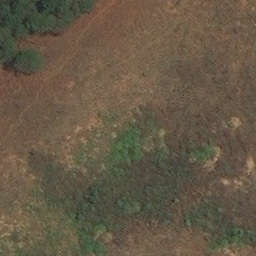

In [56]:
im = Image.open(test_image)
im

In [57]:
from torch import nn

inputs = feature_extractor(images=im, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=im.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

In [58]:
pred_seg

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]])

In [60]:
import matplotlib.pyplot as plt

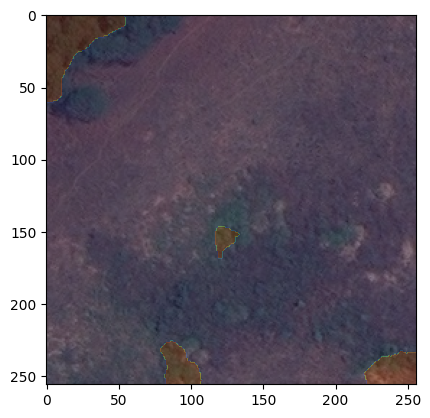

In [65]:
plt.imshow(im, cmap='gray')
plt.imshow(pred_seg, cmap='jet', alpha=0.25)